In [152]:
import numpy as np 
from matplotlib import pyplot as plt 
import math
import os

In [153]:
class PGMImage:
    def __init__(self, file_path=None):
        self.magic_number = None
        self.width = 0
        self.height = 0
        self.maxval = 0
        self.pixels = []
        self.pixels_2d = [[]]

        if file_path:
            self.mypgmread(file_path)
            self.pixels_2d = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width))


    def mypgmread(self, file_path):
        with open(file_path, 'rb') as file:
            self.magic_number = file.readline().strip().decode('ascii')

            line = file.readline().strip()
            while line.startswith(b'#'): 
                line = file.readline().strip()

            self.width, self.height = map(int, line.split())
            self.maxval = int(file.readline().strip())
            data = file.read()
            self.pixels = list(data)

    def modify_pixels(self, row_start, row_end, new_value):
        pixels_2d = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width))
        pixels_2d[row_start:row_end, :] = new_value
        self.pixels = pixels_2d.flatten().tolist()

    def mypgmwrite(self, filename):
        pixel_array = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width))

        with open(filename, 'wb') as file:
            file.write(f"{self.magic_number}\n".encode())
            file.write(f"{self.width} {self.height}\n".encode())
            file.write(f"{self.maxval}\n".encode())
            pixel_array.tofile(file)

####################################################################################################################################################
############################## LAB-01 FONKSİYONLARI ################################################################################################
####################################################################################################################################################

    def myImageLinearScale(self, pixel_array):  # pixel değerlerini normalize etme fonksiyonu
        min_pixel_value = np.min(self.pixels)  # pixel değerinin minimumunu belirler
        max_pixel_value = np.max(self.pixels)  # pixel değerinin maksimumunu belirler

        # Check if max and min are the same (to avoid division by zero)
        if max_pixel_value == min_pixel_value:
            self.pixels = [0] * len(self.pixels)  # All pixels are the same, set everything to 0
        else:
            # Pixels listesindeki her değeri min/max değerleri arasında normalize eder ve 0-255 aralığına getirir
            self.pixels = [int(self.maxval * (pixel - min_pixel_value) / (max_pixel_value - min_pixel_value))
                        for pixel in self.pixels]

        return self.pixels

    def myImageNegative(self): # görüntünün negatifini alma fonksiyonu
        # her bir pixel değerini max değerden çıkarır böylelikle bütü değerler ters çevirilmiş olur
        self.pixels = [self.maxval - pixel for pixel in self.pixels] 
        self.pixels = self.myImageLinearScale(self.pixels) # pixeller scale edilir

    def myImageLogTransform(self): # log transformu fonksiyonu
        # her bir pixel değeri için ders kitabındaki logaritma formül uygulanmıştır.
        self.pixels = [np.log(1 + pixel) for pixel in self.pixels]
        self.pixels = self.myImageLinearScale(self.pixels) # pixeller scale edilir
        
        
    def myImageGammaTransform(self, gamma): # gama transformu fonksiyonu girdi olarak gamanın değeri verilebilir
        # yine her bir pixel için ders kitbında verilen Power-Laz(gama) formülü uygulanır
        self.pixels = [int(self.maxval * (pixel / self.maxval) ** gamma) for pixel in self.pixels]
        self.pixels = self.myImageLinearScale(self.pixels) # pixeller scale edilir


    def myImageCorrelation(self, kernel): # kernel dışarıdan verilir
        k_height, k_width = kernel.shape # kernelin yükseklik ve genişliği .shape ile elde edilir
        g = np.zeros((self.height, self.width), dtype=np.float32) # çıkış değerini tutmak için imagein boyutlarında 0'lardan oluşan liste oluşturulur
        pixels_2d = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width)) # orjinal imagein pixelleri boyutlandırlır
        
        for x in range(0 , self.height): # orjinal görüntünün her pixelinde işlem yapmak için for döngüsü kurulur
            for y in range(0, self.width):
                for s in range(-k_height//2, k_height//2): # kernelin her bir değerinde işlem yapmak için for döngüleri kurulur
                    for t in range(-k_width//2, k_width//2):
                        if x+s >= 0 and x+s < self.height and y+t >= 0 and y+t < self.width: # sınır noktalar tanımlanır
                                g[x][y] += kernel[s][t] * pixels_2d[x+s][y+t] # çıkış değerine kernelin ile orjinal görüntünün her bir pixel değeriyle çarpılıp toplanmış değeri atanır
        
        #self.pixels = self.myImageLinearScale(self.pixels) # pixeller scale edilir
        return g # çıkış değeri iki boyutlu olarak döndürülür

    def myImageMedianFilter(self, k_height, k_width):
        g = np.zeros((self.height, self.width), dtype=np.float32)
        pixels_2d = np.array(self.pixels, dtype=np.uint8).reshape((self.height, self.width))
        for x in range(0 , self.height):
            for y in range(0, self.width):
                kernel_array = [] # kernel in içindeki her bir değeri tutmak için oluşturulur
                for s in range(-k_height//2, k_height//2): # kernelin her bir değerini döner
                    for t in range(-k_width//2, k_width//2):
                        if x+s >= 0 and x+s < self.height and y+t >= 0 and y+t < self.width: 
                            kernel_array.append(pixels_2d[x+s][y+t]) # komşu pixelleri listenin içinde tutar
                g[x][y] = np.median(kernel_array) # komşu pixellerin medianını alır ve orjinal görüntünün o an işlenen pixeline yazar
        self.pixels = self.myImageLinearScale(self.pixels) # pixeller scale edilir

        return g  # çıkış değeri iki boyutlu olarak döndürülür
        


####################################################################################################################################################
############################## LAB-02 FONKSİYONLARI ################################################################################################
####################################################################################################################################################

    def myGaussianKernel(self, size, sigma): # gauss kernelini oluşturmak için kullanılan fonksiyon
        kernel = np.zeros((size, size), dtype=np.float32) # boş kernel oluşturulur
        center = size // 2 # merkez belirlenir
        
        for x in range(size):
            for y in range(size): 
                x_distance = (x - center) ** 2 # gauss simetrik olduğundan sağ ve sol içinde aynı uzaklık kullanılır
                y_distance = (y - center) ** 2
                kernel[x, y] = np.exp(-(x_distance + y_distance) / (2 * sigma ** 2)) # boş kernelin içine gauss denkleminden elde edilen veriler girilir
        
        kernel /= np.sum(kernel) # kernelin içindeki değerler toplama bölünür scale etmek için
        
        return kernel

    def myHistogramEqualization(self): # histogram eşitleme fonksiyonu
        pixel = np.zeros((self.height, self.width), dtype=np.float32) # boş pixel değerleri  oluşturulur.

        hist, _ = np.histogram(self.pixels, 256, [0, 256]) # pixels değerlerine göre historam oluşturulur.
        
        cdf = np.zeros(256, dtype=np.float32) # kümülatif dağılım için boş dizi oluşturulur.
        cdf[0] = hist[0] # ilk histogram değeri cdf e atanır

        for i in range(1, 256):
            cdf[i] = hist[i] + cdf[i - 1] # önceki cdf değerine histogram değeri eklenir

        cdf_normalized = cdf / cdf[-1]  # cdf normalize edilir bütün değerler 0-1 aralığına sıkıştırılır

        for i in range(256): # her bir yoğunluk seviyesine yeni bir piksel değeri atanır
            pixel_value = int(cdf_normalized[i] * 255)
            cdf[i] = pixel_value

        for i in range(len(self.pixels)): # Görüntüdeki her piksel değeri, yeni hesaplanan cdf değerine göre değiştirilir.
            self.pixels[i] = cdf[self.pixels[i]]

        return self.pixels, cdf_normalized  



####################################################################################################################################################
############################## LAB-03 FONKSİYONLARI ################################################################################################
####################################################################################################################################################

# 2D Fourier Dönüşümünü hesaplamak için fonksiyon
    def my2Dfft(self, image = None):
        try:
            if image:
                pass
            else:
                image = self.pixels_2d
        
        except:
            pass
        
        fourier_array = np.zeros((self.height, self.width), dtype=complex)  # Fourier Dönüşümü sonucunu tutmak için boş bir karmaşık (complex) dizi oluştur
        for i in range(0 , self.height):     # Satır bazında 1D FFT uygulanır.
            fourier_array[i] = np.fft.fft(image[i])
        
        for k in range(0 , self.width):     # Satır bazındaki FFT sonucuna sütun bazında 1D FFT uygulanır.
            fourier_array[: , k] = np.fft.fft(fourier_array[: , k])

        return fourier_array     # Sonuç olarak 2D FFT'yi döndür


# Ortalanmış Fourier dönüşüm maskesi uygulayan fonksiyon
    def centered_fourier(self):
        centered_mask = np.zeros((self.height, self.width), dtype=complex)
        for x in range(0 , self.height):
            for y in range(0 , self.width):
                centered_mask[x][y] = (-1)**(x + y)

        return centered_mask * self.pixels_2d


# 2D Ters Fourier Dönüşümünü hesaplamak için fonksiyon
    def my2Difft(self, image = None):
        try:
            if image:
                pass
            else:
                image = self.pixels_2d
        except:
            pass    
        
        conj_input = np.conj(image)     # Giriş görüntüsünün konjugesini al
        conj_output = self.my2Dfft(conj_input) # konjugesi alınmış görüntünün fourier transformunu al
        inverse_conj_output = conj_output / (self.height * self.width) # Çıktıyı satır*sütun değerine böl
        inverse_image = np.conj(inverse_conj_output) # çıkış değerinin de konjugesi alınır ve original image elde edilir.

        return inverse_image

FOURİER TRASNFORM

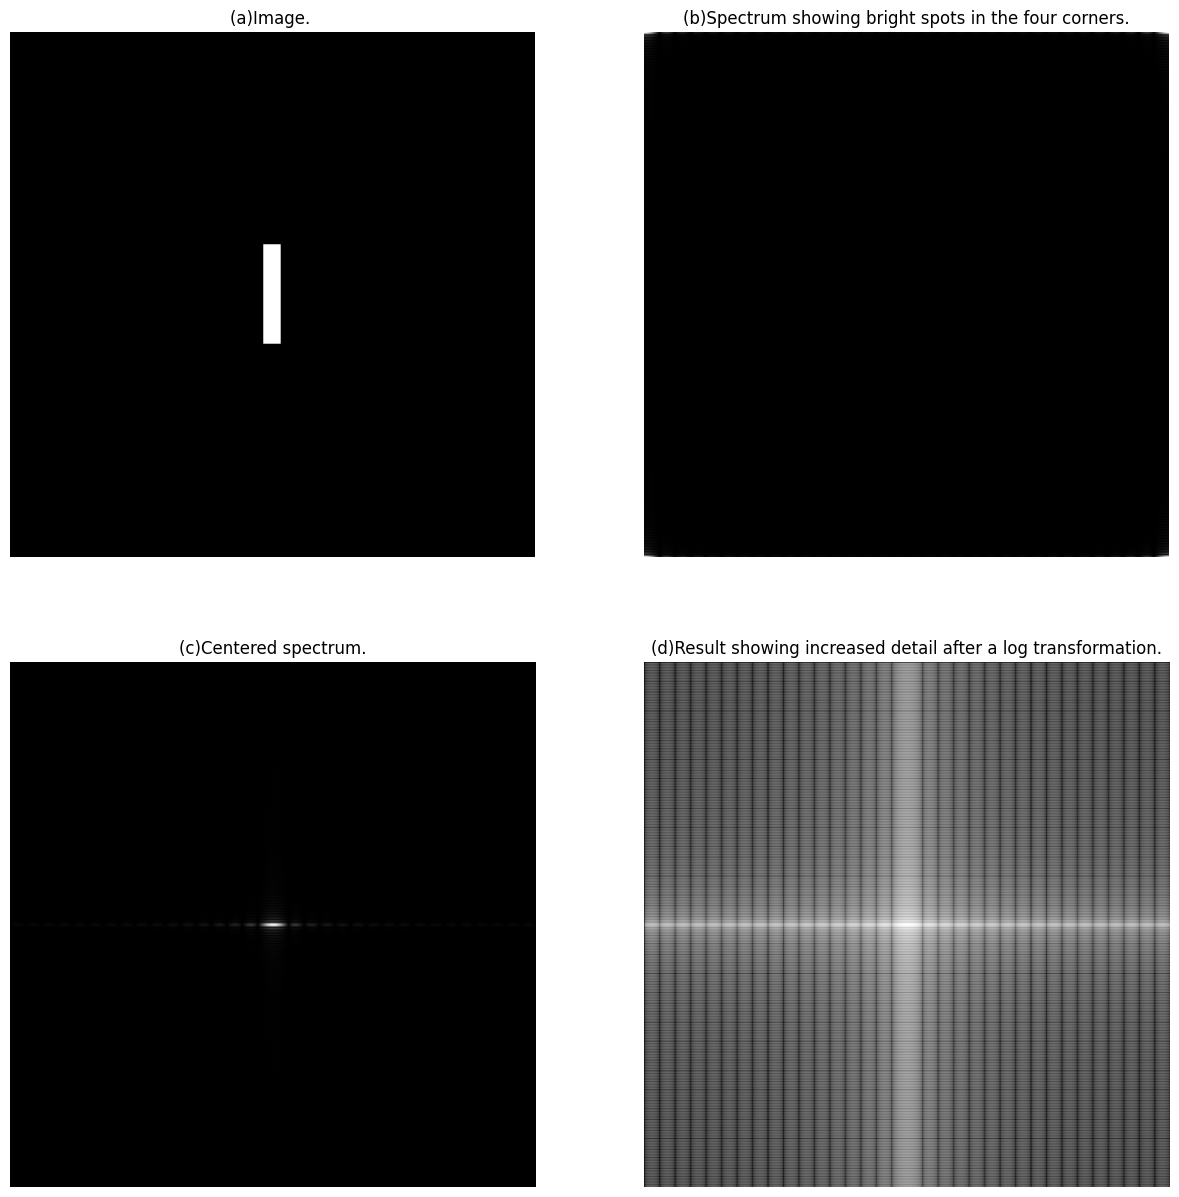

In [154]:
pgm_image = PGMImage('Fig0424(a)(rectangle).pgm')

pgm_image_fourier = PGMImage('Fig0424(a)(rectangle).pgm')
four_corner = pgm_image.my2Dfft()


centered_four =pgm_image.centered_fourier()
centered_fourierr = pgm_image_fourier.my2Dfft(centered_four)

log_transformed_fourier = 1 + np.log10(np.abs(centered_fourierr) + 1)

plt.figure(figsize=(15 ,15))

plt.subplot(2, 2, 1)
plt.title("(a)Image. ")
plt.axis('off')
plt.imshow(pgm_image.pixels_2d, cmap='gray')

plt.subplot(2, 2, 2)
plt.title("(b)Spectrum showing bright spots in the four corners.")
plt.axis('off')
plt.imshow(np.abs(four_corner), cmap='gray')


plt.subplot(2, 2, 3)
plt.title("(c)Centered spectrum.")
plt.axis('off')
plt.imshow(np.abs(centered_fourierr), cmap='gray')

plt.subplot(2, 2, 4)
plt.title("(d)Result showing increased detail after a log transformation.")
plt.axis('off')
plt.imshow(log_transformed_fourier, cmap='gray')


INVERSE FOURİER TRANSFORM

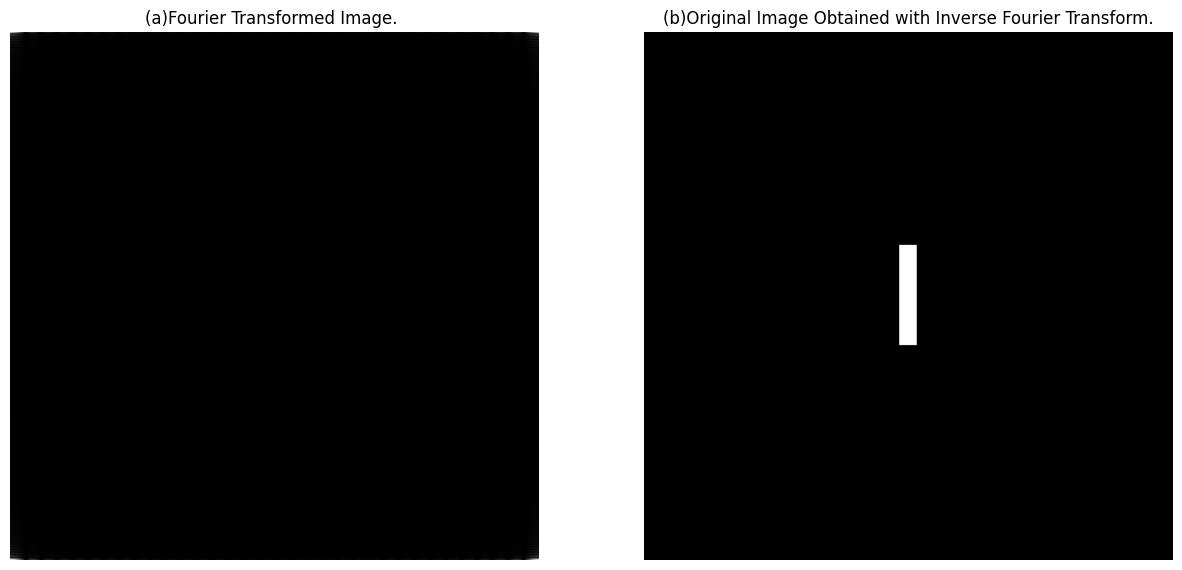

In [155]:
pgm_image_fourier = PGMImage('Fig0424(a)(rectangle).pgm')
four_corner = pgm_image.my2Dfft()

inverse_transform = pgm_image.my2Difft(four_corner)


plt.figure(figsize=(15 ,15))

plt.subplot(1, 2, 1)
plt.title("Fourier Transformed Image. ")
plt.axis('off')
plt.imshow(np.abs(four_corner), cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Original Image Obtained with Inverse Fourier Transform.")
plt.axis('off')
plt.imshow(np.abs(inverse_transform), cmap='gray')
